## <center>自编码网络</center>

### 1 自编码网络介绍
自编码 (Auto-Encoder) 网络是输入等于输出的网络,最基本的模型可以视为三层神经网络,即输入层,隐藏层,输出层.其中,输入层的样本也会充当输出层的标签,换句话说,这个神经网络就是一种尽可能复现输入信号的神经网络.
<br/><br/>
<center><img src="./img/14/1.png" width="500"/></center>
<br/>
其中,从输入到中间状态叫编码,从中间状态再回到输出的过程叫做解码.这样构成的自动编码器可以捕捉代表输入数据的最重要的因素,类似 PCA 算法.

如果激活函数不适用 sigmoid 函数,而使用线性函数,那么便是 PCA 模型了.

#### (1) 加载 MNIST 数据

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./data/mnist/",one_hot = True)

Extracting ./data/mnist/train-images-idx3-ubyte.gz
Extracting ./data/mnist/train-labels-idx1-ubyte.gz
Extracting ./data/mnist/t10k-images-idx3-ubyte.gz
Extracting ./data/mnist/t10k-labels-idx1-ubyte.gz


#### (2) 定义网络模型
为了使用自编码器,可以将原始图片从 784 维降到 256 维,用同样的方式再次降维到 128,最终还原到原来的图片.
<br/>
<center><img src="./img/14/2.png" width="700"/></center>
<br/>

In [2]:
# 网络模型参数
learning_rate = 0.01
n_hidden_1 = 256 # 第一层256个节点
n_hidden_2 = 128 # 第二层128个节点
n_input = 784 # MNIST data 输入 (img shape: 28*28)

# 占位符
x = tf.placeholder("float", [None, n_input])#输入
y = x #输出


#学习参数
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.zeros([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.zeros([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.zeros([n_hidden_1])),
    'decoder_b2': tf.Variable(tf.zeros([n_input])),
}


# 编码
def encoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),biases['encoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    return layer_2


# 解码
def decoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),biases['decoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),biases['decoder_b2']))
    return layer_2

#输出的节点
encoder_out = encoder(x)
pred = decoder(encoder_out)

# 使用平方差为cost
cost = tf.reduce_mean(tf.pow(y - pred, 2))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

#### (3) 开始训练
一次取 256 条数据,将所欲的训练数据进行 20 次迭代训练

Epoch: 0001 cost= 0.091542944
Epoch: 0006 cost= 0.064313591
Epoch: 0011 cost= 0.057515111
Epoch: 0016 cost= 0.054502927


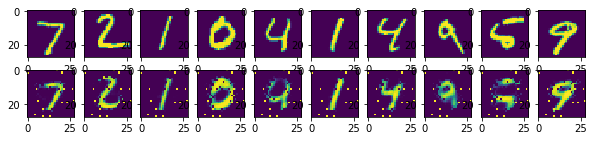

In [3]:
# 训练参数
training_epochs = 20  #一共迭代20次
batch_size = 256     #每次取256个样本
display_step = 5     #迭代5次输出一次信息
show_num = 10

# 启动绘话
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    
    total_batch = int(mnist.train.num_examples/batch_size)
    # 开始训练
    for epoch in range(training_epochs):#迭代
        
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)#取数据
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_xs})# 训练模型
        if epoch % display_step == 0:# 现实日志信息
            print("Epoch:", '%04d' % (epoch+1),"cost=", "{:.9f}".format(c))
    reconstruction = sess.run(pred,feed_dict={x:mnist.test.images[:show_num]})
    f,a = plt.subplots(2,10,figsize=(10,2))
    for i in range(show_num):
        a[0][i].imshow(np.reshape(mnist.test.images[i],(28,28)))
        a[1][i].imshow(np.reshape(reconstruction[i],(28,28)))
    plt.draw()

#### (4) 可视化对比输入和输出

### 2 Encoder 编码器 (线性解码器)

Encoder 编码器工作原理与 AutoEncoder 相同，我们将编码得到的低维“特征值”在低维空间中可视化出来，直观显示数据的聚类效果。具体地说，将 784 维的 MNIST 数据一步步的从 784 到 128 到 64 到 10 最后降至 2 维，在 2 维坐标系中展示，<font color='red'>在编码器的最后一层中我们不采用Sigmoid激活函数，而是将采用默认的线性激活函数，使输出为（$- \infty$，$+ \infty$）。</font>

<font color='red'>注意</font><br/>
要想获取更好的特征提取效果,可以将压缩层数变多,每层压缩一点点,由于 sigmoid 函数的缺陷,无法使用更深的层,所以这里只用了 4 层压缩,后面可以使用栈式自编码器解决

#### (1) 加载 MNIST 数据

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./data/mnist/", one_hot=False)

Extracting ./data/mnist/train-images-idx3-ubyte.gz
Extracting ./data/mnist/train-labels-idx1-ubyte.gz
Extracting ./data/mnist/t10k-images-idx3-ubyte.gz
Extracting ./data/mnist/t10k-labels-idx1-ubyte.gz


#### (2) 定义网络模型
这里使用线性解码器,在编码的最后一层,没有进行 sigmoid 变换,这里因为生成的二维数据特征已经极为重要,所以我们认为少一些变换可以最大地保留原有的主要特征.

In [5]:
learning_rate = 0.01
training_epochs = 10
batch_size = 256
display_step = 1
show_num = 10
n_input = 784
x = tf.placeholder(dtype=tf.float32, shape=[None, n_input])
y = x
n_hidden_1 = 128
n_hidden_2 = 64
n_hidden_3 = 10
n_hidden_4 = 2
weights = {
    'encoder_h1': tf.Variable(tf.truncated_normal([n_input, n_hidden_1],)),
    'encoder_h2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2],)),
    'encoder_h3': tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_3],)),
    'encoder_h4': tf.Variable(tf.truncated_normal([n_hidden_3, n_hidden_4],)),
    'decoder_h1': tf.Variable(tf.truncated_normal([n_hidden_4, n_hidden_3],)),
    'decoder_h2': tf.Variable(tf.truncated_normal([n_hidden_3, n_hidden_2],)),
    'decoder_h3': tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_1],)),
    'decoder_h4': tf.Variable(tf.truncated_normal([n_hidden_1, n_input],)),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'encoder_b3': tf.Variable(tf.random_normal([n_hidden_3])),
    'encoder_b4': tf.Variable(tf.random_normal([n_hidden_4])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_3])),
    'decoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b3': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b4': tf.Variable(tf.random_normal([n_input])),
}
def encoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['encoder_h3']),
                                   biases['encoder_b3']))
    # 为了便于编码层的输出，编码层随后一层不使用激活函数
    layer_4 = tf.add(tf.matmul(layer_3, weights['encoder_h4']),
                                    biases['encoder_b4'])
    return layer_4

def decoder(x):
    # 在 decoder 中需要使用激活函数
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['decoder_h3']),
                                biases['decoder_b3']))
    layer_4 = tf.nn.sigmoid(tf.add(tf.matmul(layer_3, weights['decoder_h4']),
                                biases['decoder_b4']))
    return layer_4

encoder_output = encoder(x)
pred = decoder(encoder_output)
cost = tf.reduce_mean(tf.pow(y - pred, 2))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

#### (3) 开始训练
一次取 256 条数据,将所欲的训练数据进行 10 次迭代训练

Epoch: 0000 cost= 0.058859464
Epoch: 0001 cost= 0.053502697
Epoch: 0002 cost= 0.049597926
Epoch: 0003 cost= 0.047194544
Epoch: 0004 cost= 0.046809752
Epoch: 0005 cost= 0.043539543
Epoch: 0006 cost= 0.045643564
Epoch: 0007 cost= 0.041946925
Epoch: 0008 cost= 0.044246595
Epoch: 0009 cost= 0.042685244


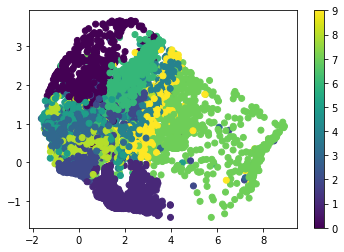

In [6]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    total_batch = int(mnist.train.num_examples/batch_size)
    for epoch in range(training_epochs):
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            _, loss = sess.run([optimizer, cost], feed_dict={x: batch_xs})
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch), "cost=", "{:.9f}".format(loss))
            
#     reconstruction = sess.run(pred,feed_dict={x:mnist.test.images[:show_num]})
#     f,a = plt.subplots(2,10,figsize=(10,2))
#     for i in range(show_num):
#         a[0][i].imshow(np.reshape(mnist.test.images[i],(28,28)))
#         a[1][i].imshow(np.reshape(reconstruction[i],(28,28)))
#     plt.show()
        
    encoder_result = sess.run(encoder_output, feed_dict={x: mnist.test.images})
    plt.scatter(encoder_result[:, 0], encoder_result[:, 1], c=mnist.test.labels)
    plt.colorbar()
    plt.show()